In [1]:
import argparse
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.custom_recurrents import AttentionDecoder

Using TensorFlow backend.


In [2]:
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import GRU
from keras.optimizers import Adam

from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers import Input

In [3]:
filepath=unicode('/mnt/nas/eeg/processed_data_RNN/','utf8')
print filepath
fileName = sorted(os.listdir(filepath))
len(fileName)

/mnt/nas/eeg/processed_data_RNN/


29

In [4]:
data = pd.read_pickle(filepath+fileName[0])

In [5]:
W = data.iloc[0]

In [6]:
W.index

Index([u'E1-M2_delta_Energy_phase_0', u'E1-M2_theta_Energy_phase_0',
       u'E1-M2_alpha_Energy_phase_0', u'E1-M2_beta_Energy_phase_0',
       u'E1-M2_gamma_Energy_phase_0', u'E1-M2_low_alpha_Energy_phase_0',
       u'E1-M2_high_alpha_Energy_phase_0', u'E1-M2_Energy_phase_0',
       u'E1-M2Energyratio1_phase_0', u'E1-M2Energyratio2_phase_0',
       ...
       u'Snore_amin_phase_29', u'Snore_amean_phase_29', u'Snore_astd_phase_29',
       u'Snore_aEnergy_phase_29', u'Snore_bmax_phase_29',
       u'Snore_bmin_phase_29', u'Snore_bmean_phase_29', u'Snore_bstd_phase_29',
       u'Snore_bEnergy_phase_29', u'label'],
      dtype='object', length=23101)

In [7]:
data.columns

Index([u'E1-M2_delta_Energy_phase_0', u'E1-M2_theta_Energy_phase_0',
       u'E1-M2_alpha_Energy_phase_0', u'E1-M2_beta_Energy_phase_0',
       u'E1-M2_gamma_Energy_phase_0', u'E1-M2_low_alpha_Energy_phase_0',
       u'E1-M2_high_alpha_Energy_phase_0', u'E1-M2_Energy_phase_0',
       u'E1-M2Energyratio1_phase_0', u'E1-M2Energyratio2_phase_0',
       ...
       u'Snore_amin_phase_29', u'Snore_amean_phase_29', u'Snore_astd_phase_29',
       u'Snore_aEnergy_phase_29', u'Snore_bmax_phase_29',
       u'Snore_bmin_phase_29', u'Snore_bmean_phase_29', u'Snore_bstd_phase_29',
       u'Snore_bEnergy_phase_29', u'label'],
      dtype='object', length=23101)

In [43]:
filepath = unicode ('check_point/', 'utf8')
print filepath

check_point/


In [44]:
weights_file = filepath + 'weights.49_0.8434.hdf5'

In [9]:
sorted(os.listdir(filepath))

[u'.ipynb_checkpoints',
 u'weights.00_0.3968.hdf5',
 u'weights.01_0.5214.hdf5',
 u'weights.02_0.6046.hdf5',
 u'weights.03_0.6637.hdf5',
 u'weights.04_0.6913.hdf5',
 u'weights.06_0.7213.hdf5',
 u'weights.07_0.7322.hdf5',
 u'weights.08_0.7484.hdf5',
 u'weights.09_0.7553.hdf5',
 u'weights.10_0.7765.hdf5',
 u'weights.11_0.7873.hdf5',
 u'weights.14_0.7922.hdf5',
 u'weights.16_0.7986.hdf5',
 u'weights.17_0.8075.hdf5',
 u'weights.19_0.8134.hdf5',
 u'weights.24_0.8163.hdf5',
 u'weights.28_0.8213.hdf5',
 u'weights.29_0.8227.hdf5',
 u'weights.31_0.8262.hdf5',
 u'weights.35_0.8291.hdf5',
 u'weights.37_0.8336.hdf5',
 u'weights.49_0.8434.hdf5']

In [10]:
import json
import csv
import random

import numpy as np
from keras.utils.np_utils import to_categorical

random.seed(1984)

INPUT_PADDING = 50
OUTPUT_PADDING = 100


class Vocabulary(object):

    def __init__(self, vocabulary_file, padding=None):
        """
            Creates a vocabulary from a file
            :param vocabulary_file: the path to the vocabulary
        """
        self.vocabulary_file = vocabulary_file
        with open(vocabulary_file, 'r') as f:
            self.vocabulary = json.load(f)

        self.padding = padding
        self.reverse_vocabulary = {v: k for k, v in self.vocabulary.items()}

    def size(self):
        """
            Gets the size of the vocabulary
        """
        return len(self.vocabulary.keys())

    def string_to_int(self, text):
        """
            Converts a string into it's character integer 
            representation
            :param text: text to convert
        """
        characters = list(text)

        integers = []

        if self.padding and len(characters) >= self.padding:
            # truncate if too long
            characters = characters[:self.padding - 1]

        characters.append('<eot>')

        for c in characters:
            if c in self.vocabulary:
                integers.append(self.vocabulary[c])
            else:
                integers.append(self.vocabulary['<unk>'])


        # pad:
        if self.padding and len(integers) < self.padding:
            integers.extend([self.vocabulary['<unk>']]
                            * (self.padding - len(integers)))

        if len(integers) != self.padding:
            print(text)
            raise AttributeError('Length of text was not padding.')
        return integers

    def int_to_string(self, integers):
        """
            Decodes a list of integers
            into it's string representation
        """
        characters = []
        for i in integers:
            characters.append(self.reverse_vocabulary[i])

        return characters


In [11]:
from visualize import Visualizer

In [41]:
def create_model():
    i = Input(shape=(30*3, 770), dtype='float32')
    g0 = GRU(256, return_sequences=True, activation='tanh')(i)
    # g1 = GRU(128, return_sequences=True, activation='tanh')(g0)
    # g2 = GRU(64, return_sequences=True, activation='tanh')(g1)
    enc = Bidirectional(GRU(128, return_sequences=True, activation='tanh'), merge_mode='concat')(g0)
    dec = AttentionDecoder(units=64,output_dim=32)(enc)
    # b0 = BatchNormalization()(dec)
    # d0 = Dropout(0.5)(b0)
    # g3 = GRU(64, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform')(dec)
    g4 = GRU(32, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform')(dec)
    b1 = BatchNormalization()(g4)
    d1 = Dropout(0.5)(b1)
    o = Dense(5, activation='softmax')(d1)
    model = Model(inputs=i,outputs=o)
    
    adam = Adam(lr=0.00005, clipnorm=5)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    print model.summary()
    return model

In [32]:
previous_column = np.array(W.index[:-1])
current_column = np.array(W.index[:-1])
later_column = np.array(W.index[:-1])

In [33]:
for i in range(len(previous_column)):
    previous_column[i] = 'previous_' + previous_column[i]
    current_column[i] = 'current_' + current_column[i]
    later_column[i] = 'later_' + later_column[i]

In [35]:
in_v = str(previous_column)

In [36]:
in_v

"['previous_E1-M2_delta_Energy_phase_0'\n 'previous_E1-M2_theta_Energy_phase_0'\n 'previous_E1-M2_alpha_Energy_phase_0' ..., 'previous_Snore_bmean_phase_29'\n 'previous_Snore_bstd_phase_29' 'previous_Snore_bEnergy_phase_29']"

In [49]:
def mix(data):
    data.label = data.label.replace(np.nan, '?')
    train = data[data.label != '?']
    # train = train[data.label != '0']
    # train = train[data.label != '-1']
    # train = train[data.label != '-2']
    # train = train[data.label != '-3']
    train = train.replace([np.inf, -np.inf], np.nan)
    train = train.fillna(value = 0)
    train = np.array(train)
    train = train.reshape(-1, 23101)
    # train = train.reshape(-1, 3301)
    temp = train[::, :-1]
    temp_l = train[::,:-1]
    temp_r = train[::,:-1]
    temp_l[:-1,::] = temp[1:,::]
    temp_r[1:,::] = temp[:-1,::]
    temp = np.append(temp_l, temp, axis=1)
    temp = np.append(temp, temp_r, axis=1)
    label = train[1:-1,-1]
    temp = temp[1:-1,::]
    # train = train[::,:-1].reshape(-1,30,770)
    # temp = temp.reshape(-1,30,770)
    # temp = np.concatenate([temp,temp], axis=2)
    # temp = np.concatenate([temp,train], axis=2)
    # temp[:-1,::,:770] = train[:-1,::,::] - train[1:,::,::]
    # temp[1:,::,770:1540] = train[:-1,::,::] - train[1:,::,::]
    return temp, label

In [50]:
d, label = mix(data)

In [54]:
activation_map = np.squeeze(proba_model.predict(np.array(d[0]).reshape(1,90,770)))

In [55]:
activation_map

array([ 0.20470276,  0.20054503,  0.1991874 ,  0.19934139,  0.19622341], dtype=float32)

In [ ]:
plt.clf()

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np 

In [4]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation = 90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [203]:
cm = np.array([[1061,72,5,1,16],
 [48,546,187,1,66],
 [5,102,1503,74,35],
 [0,0,82,623,0],
 [9,58,28,0,544]])

In [10]:
cm = np.array([
[1039,   89,    3,    2,   21],
 [  49,  550,  193,    1,   54],
 [   4,  128, 1474,   78,   36],
 [   0,    0,   96,  609,    0],
 [  11,   71,   37,    0,  520]

])

In [11]:
print cm

[[1039   89    3    2   21]
 [  49  550  193    1   54]
 [   4  128 1474   78   36]
 [   0    0   96  609    0]
 [  11   71   37    0  520]]


In [12]:
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
print cm_normalized

[[ 0.9   0.08  0.    0.    0.02]
 [ 0.06  0.65  0.23  0.    0.06]
 [ 0.    0.07  0.86  0.05  0.02]
 [ 0.    0.    0.14  0.86  0.  ]
 [ 0.02  0.11  0.06  0.    0.81]]


In [13]:
plt.figure(figsize=(5,5), dpi=120)
ind_array = np.arange(5)
x, y = np.meshgrid(ind_array, ind_array)

In [14]:
thresh = cm_normalized.max() / 2.
for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if (c > thresh):
        plt.text(x_val, y_val, '%0.2f' %(c,), color='White', fontsize=10, va='center', ha='center')
    else:
        plt.text(x_val, y_val, '%0.2f' %(c,), color='Black', fontsize=10, va='center', ha='center')

In [15]:
labels = ['W','N1','N2','N3','R']
tick_marks = np.array(range(len(labels)))+0.5

In [16]:
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

In [17]:
plot_confusion_matrix(cm_normalized, title='Proposed Method (Unbalanced)')  

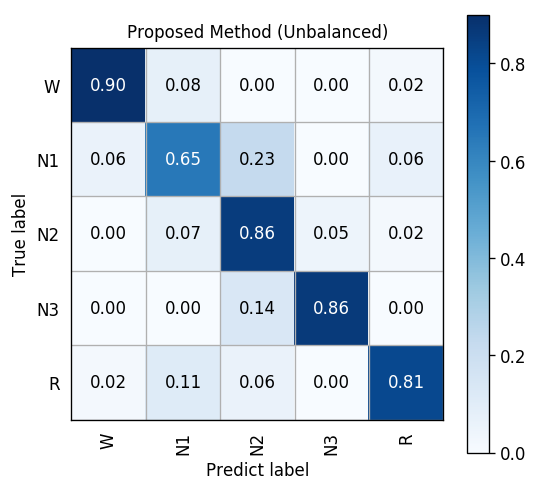

In [18]:
plt.show()

In [28]:
cm = np.array([
    [0.9448, 0.7018, 0.8327, 0.8913, 0.8230],
    [0.9186, 0.6439, 0.8743, 0.8837, 0.8513],
    [0.9315, 0.6716, 0.8530, 0.8875, 0.8369],
    [0.9974, 0.9906, 0.9872, 0.9969, 0.9953]
])

In [37]:
cm = np.array([
    [0.9419, 0.6563, 0.8175, 0.8826, 0.8241],
    [0.9003, 0.6494, 0.8570, 0.8638, 0.8138],
    [0.9206, 0.6528, 0.8368, 0.8731, 0.8189],
    [0.9974, 0.9685, 0.9861, 0.9967, 0.9955]
])

In [38]:
def plot_confusion_matrix(cm, title='Attention-based LSTM (Unbalanced)', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, scores)
#     plt.ylabel('True label')
#     plt.xlabel('Predict label')

In [39]:
cm_normalized = cm

In [40]:
plt.figure(figsize=(4,5), dpi=120)
ind_array1 = np.arange(4)
ind_array2 = np.arange(5)
x, y = np.meshgrid(ind_array2, ind_array1)
print x, y

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]] [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]


In [41]:
thresh = cm_normalized.max() * 0.8
print thresh
for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if (c > thresh):
        plt.text(x_val, y_val, '%0.3f' %(c,), color='White', fontsize=10, va='center', ha='center')
    else:
        plt.text(x_val, y_val, '%0.3f' %(c,), color='Black', fontsize=10, va='center', ha='center')

0.79792


In [42]:
labels = ['W','N1','N2','N3','R']
scores = ['Precision','Sensitivity','F1','Specificity']
tick_marks = np.array(range(len(labels)))+0.5

In [43]:
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

In [44]:
plot_confusion_matrix(cm_normalized, title='Attention-based LSTM (Balanced)')  

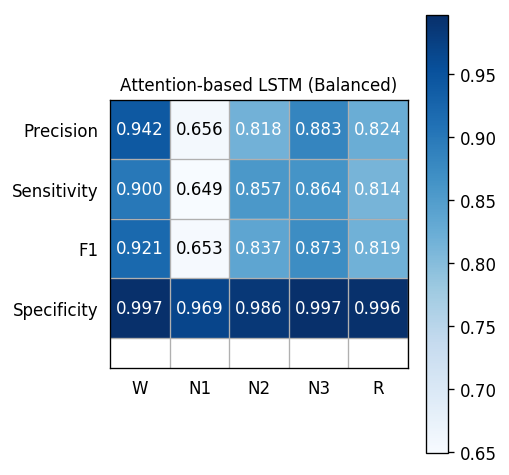

In [45]:
plt.show()